In [14]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from scipy import signal
from apis.imaging_classes import save_disp_imgs,bootstrap_disp,VirtualShotGathersFromWindows
from modules.utils import extract_ridge_ref_idx,plot_disp_curves,win_avg_psd
from modules.car_tracking_utils import plot_data
import random
import scipy
from tqdm.notebook import tqdm
# %matplotlib notebook

# Load saved surface wave windows associated with vehicle states and speeds

In [15]:
# Define the file name using an f-string to include the value of _x0: pivot.
_x0 = 600
tracking_offset = 200
_start_x = _x0 - tracking_offset
_end_x = _x0 + tracking_offset
file_name = f"data/sw_data/{_x0}.pkl"

# Open the file in binary read mode
with open(file_name, "rb") as f:
    # Load the pickled data from the file.
    windows_all = pickle.load(f)  # Load the 'windows_all' surface wave window data from the file.
    das_veh_states = pickle.load(f)  # Load the 'das_veh_states' data from the file.
    veh_speed = pickle.load(f)  # Load the 'veh_speed' data from the file.

MemoryError: 

# Get surface wave windows with different vehicle weights

## Use majority vehicle speeds

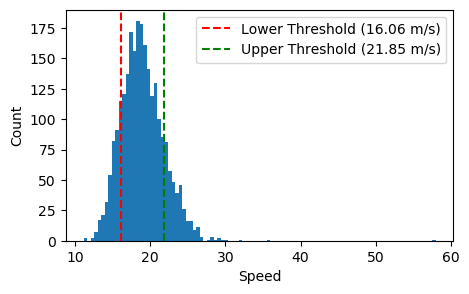

In [3]:
# Define threshold values based on one sigma away from the mode.
lower_limit = np.mean(veh_speed) - 1*np.std(veh_speed)
upper_limit = np.mean(veh_speed) + 1*np.std(veh_speed)
# Define a condition to select speeds within one sigma of the mode.
speed_idx = np.where((veh_speed >= lower_limit) & (veh_speed <= upper_limit))[0]

# Create a histogram of vehicle speeds.
fig = plt.figure(figsize=(5, 3))
plt.hist(veh_speed, bins=100)
plt.xlabel('Speed')
plt.ylabel('Count')
# Plot vertical lines to mark the threshold values.
plt.axvline(lower_limit, color='r', linestyle='--', label=f'Lower Threshold ({lower_limit:.2f} m/s)')
plt.axvline(upper_limit, color='g', linestyle='--', label=f'Upper Threshold ({upper_limit:.2f} m/s)')
# Create a legend to label the threshold lines.
plt.legend()

# Filter das_veh_states_mean and windows_all_rm to only include elements with matching indices in speed_idx.
das_veh_states = [i for j, i in enumerate(das_veh_states) if j in speed_idx]
windows_all = [i for j, i in enumerate(windows_all) if j in speed_idx]

## Spliting small, mid, and large weight vehicles

In [4]:
# Calculate the mean along the first axis
das_veh_states_mean = []
for das_veh in das_veh_states:
    mean_tmp = signal.detrend(signal.savgol_filter(das_veh.mean(0),101,3))
    mean_tmp = mean_tmp-mean_tmp[0]
    das_veh_states_mean.append(mean_tmp)

Number of Heavy Peaks: 88
Number of Mid Peaks: 1197
Number of Small Peaks: 439


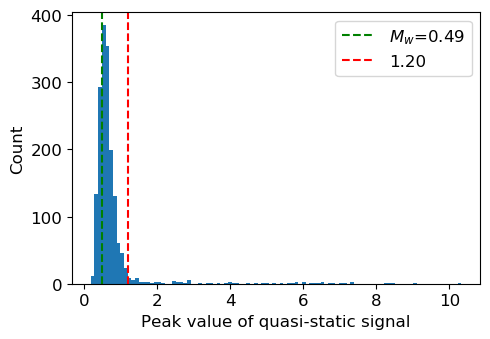

In [15]:
# Calculate the peaks of the mean values.
peaks = np.max(np.abs(das_veh_states_mean), 1)

# Create a histogram of the peaks.
fig = plt.figure(figsize=(5, 3.5))
n, bins, patches = plt.hist(peaks, bins=100)
plt.xlabel('Peak value of quasi-static signal',fontsize=12)
plt.ylabel('Count',fontsize=12)

# Calculate the mode of the peak values.
mode_peak = bins[np.argmax(n)]
# Define the threshold values.
threshold_1 = 1.2
threshold_2 = mode_peak
# Plot vertical lines to mark the thresholds.
plt.axvline(threshold_2, color='g', linestyle='--', label=f'$M_w$={threshold_2:.2f}')
plt.axvline(threshold_1, color='r', linestyle='--', label=f'{threshold_1:.2f}')
# Create a legend to label the threshold lines.
plt.legend(fontsize=12)

# Classify peaks into heavy, mid, and small based on the conditions.
heavy_idx = np.where(peaks > threshold_1)[0]
mid_idx = np.where((peaks <= threshold_1) & (peaks > threshold_2))[0]
light_idx = np.where(peaks <= threshold_2)[0]

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
# Print the number of elements in each category.
print(f'Number of Heavy Peaks: {len(heavy_idx)}')
print(f'Number of Mid Peaks: {len(mid_idx)}')
print(f'Number of Small Peaks: {len(light_idx)}')

plt.savefig(f'figures/{_x0}/hist_weight.pdf', format='pdf')

In [16]:
windows_heavy = []  
windows_mid = []    
windows_light = []  
speed_heavy = []  
speed_mid = []  
speed_light = [] 
state_heavy = []  
state_mid = []  
state_light = [] 


# Iterate through heavy_idx, mid_idx, and small_idx to collect corresponding surface wave windows.
for k in heavy_idx:
    windows_heavy.append(windows_all[k])
    speed_heavy.append(veh_speed[k])
    state_heavy.append(das_veh_states_mean[k])
for k in mid_idx:
    windows_mid.append(windows_all[k])
    speed_mid.append(veh_speed[k])
    state_mid.append(das_veh_states_mean[k])
for k in light_idx:
    windows_light.append(windows_all[k])
    speed_light.append(veh_speed[k])
    state_light.append(das_veh_states_mean[k])

## Visualize different weights vehicles in time domain

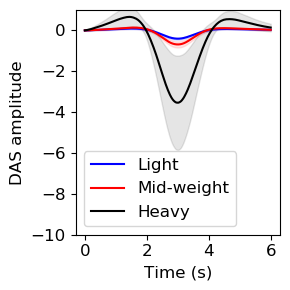

In [17]:
fig = plt.figure(figsize=(3, 3))
t_axis_tmp = np.arange(0,1500/250,1/250)
mean_light = np.mean(state_light,axis=0)
std_light = np.std(state_light,axis=0)
ci_slow = 1.96 * std_light / np.sqrt(len(state_light))

mean_mid = np.mean(state_mid,axis=0)
std_mid = np.std(state_mid,axis=0)
ci_mid = 1.96 * std_mid / np.sqrt(len(state_mid))

mean_heavy = np.mean(state_heavy,axis=0)
std_heavy = np.std(state_heavy,axis=0)
ci_heavy = 1.96 * std_heavy / np.sqrt(len(state_heavy))

plt.plot(t_axis_tmp, mean_light,'b',label='Light')
plt.fill_between(t_axis_tmp, mean_light - std_light, mean_light + std_light, color='blue', 
                 alpha=0.1)

plt.plot(t_axis_tmp, mean_mid,'r',label='Mid-weight')
plt.fill_between(t_axis_tmp, mean_mid - std_mid, mean_mid + std_mid, color='red', 
                 alpha=0.1)

plt.plot(t_axis_tmp, mean_heavy,'k',label='Heavy')
plt.fill_between(t_axis_tmp, mean_heavy - std_heavy, mean_heavy + std_heavy, color='black', 
                 alpha=0.1)
plt.legend(fontsize=12)
plt.ylim([-10,1])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Time (s)',fontsize=12)
plt.ylabel('DAS amplitude',fontsize=12)
plt.tight_layout()
plt.savefig(f'figures/{_x0}/weight_time.pdf', format='pdf')

# Spectrum

In [11]:
def win_avg_psd(win_spectrum,fs,nperseg=2048):
    f, Pxx = signal.welch(win_spectrum[0].data[0,:], fs, nperseg=nperseg)
    Pxxs = np.zeros((len(win_spectrum),Pxx.shape[0]))
    for i in range(len(win_spectrum)):
        n = 0
        sw_data = win_spectrum[i].data
        Pxxs_ = np.zeros(Pxx.shape)
        for j in range(sw_data.shape[0]):
            n+=1
            f, Pxx = signal.welch(sw_data[j,:], fs, nperseg=nperseg)
            Pxxs_+=Pxx
        Pxxs[i,:] = Pxxs_/n    
    Pxx_avg = np.mean(Pxxs,axis=0)
    return f,Pxx_avg,Pxxs,

In [12]:
f_heavy,Pxx_avg_heavy,Pxxs_heavy = win_avg_psd(windows_heavy,250)
f_mid,Pxx_avg_mid, Pxxs_mid = win_avg_psd(windows_mid,250)
f_light,Pxx_avg_light,Pxxs_light = win_avg_psd(windows_light,250)

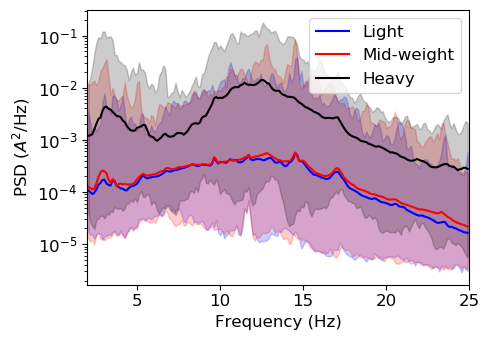

In [13]:
fig = plt.figure(figsize=(5, 3.5))


Pxx_low_light = np.min(Pxxs_light,axis=0)
Pxx_upp_light = np.max(Pxxs_light,axis=0)
plt.semilogy(f_light[(f_light>=2)&(f_light<=25)], Pxx_avg_light[(f_light>=2)&(f_light<=25)],'b',label='Light')
plt.fill_between(f_light[(f_light>=2)&(f_light<=25)], 
                 Pxx_low_light[(f_light>=2)&(f_light<=25)], 
                 Pxx_upp_light[(f_light>=2)&(f_light<=25)], 
                 color='b', alpha=0.2)

Pxx_low_mid = np.min(Pxxs_mid,axis=0)
Pxx_upp_mid = np.max(Pxxs_mid,axis=0)
plt.semilogy(f_mid[(f_mid>=2)&(f_mid<=25)], Pxx_avg_mid[(f_mid>=2)&(f_mid<=25)],'r',label='Mid-weight')
plt.fill_between(f_mid[(f_mid>=2)&(f_mid<=25)], 
                 Pxx_low_mid[(f_mid>=2)&(f_mid<=25)], 
                 Pxx_upp_mid[(f_mid>=2)&(f_mid<=25)], 
                 color='r', alpha=0.2)

Pxx_low_heavy = np.min(Pxxs_heavy,axis=0)
Pxx_upp_heavy = np.max(Pxxs_heavy,axis=0)
plt.semilogy(f_heavy[(f_heavy>=2)&(f_heavy<=25)], Pxx_avg_heavy[(f_heavy>=2)&(f_heavy<=25)],'k',label='Heavy')
plt.fill_between(f_heavy[(f_heavy>=2)&(f_heavy<=25)], 
                 Pxx_low_heavy[(f_heavy>=2)&(f_heavy<=25)], 
                 Pxx_upp_heavy[(f_heavy>=2)&(f_heavy<=25)], 
                 color='k', alpha=0.2)

plt.xlabel('Frequency (Hz)',fontsize=12)
plt.ylabel('PSD ($A^2$/Hz)',fontsize=12)
plt.xlim([2,25])
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'figures/{_x0}/weight_PSD.pdf', format='pdf')

# Imaging for different weights

## Plot

figures/600/sg_heavy_cars.pdf has saved...
saving figures/600/disp_heavy_cars_no_norm.pdf...
saving figures/600/disp_heavy_cars_no_enhance.pdf...
figures/600/sg_mid_cars.pdf has saved...
saving figures/600/disp_mid_cars_no_norm.pdf...
saving figures/600/disp_mid_cars_no_enhance.pdf...
figures/600/sg_light_cars.pdf has saved...
saving figures/600/disp_light_cars_no_norm.pdf...
saving figures/600/disp_light_cars_no_enhance.pdf...


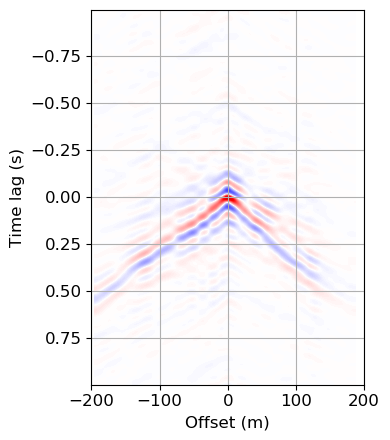

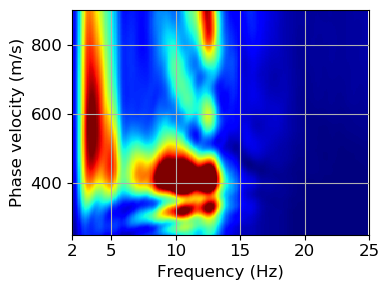

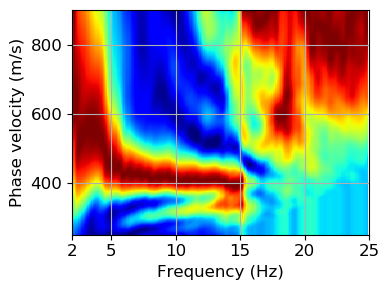

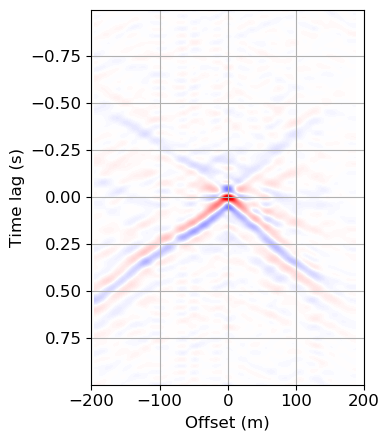

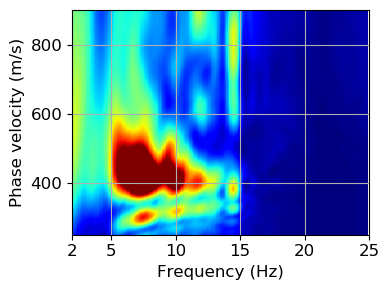

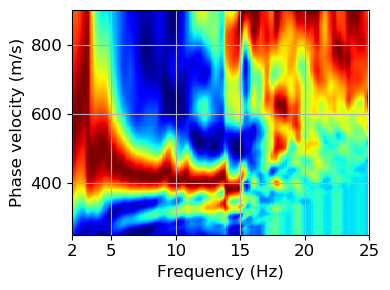

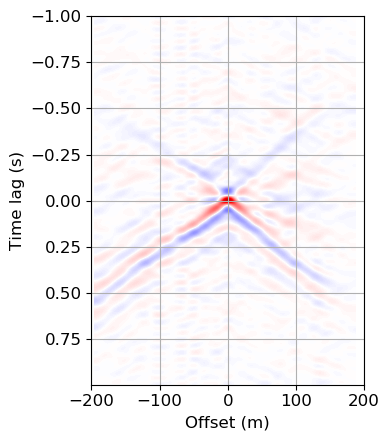

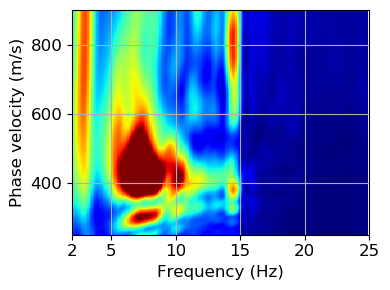

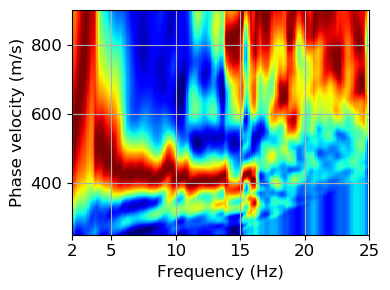

In [14]:
_min_win = np.min([len(heavy_idx),len(mid_idx),len(light_idx)])
images_heavy = save_disp_imgs(windows_heavy, 'heavy', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

sample = random.sample(range(len(windows_mid)), len(windows_heavy))
windows_mid_sample = [windows_mid[idx] for idx in sample]
images_mid = save_disp_imgs(windows_mid_sample, 'mid', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

sample = random.sample(range(len(windows_light)), len(windows_heavy))
windows_light_sample = [windows_light[idx] for idx in sample]
images_light = save_disp_imgs(windows_light_sample, 'light', _min_win, _x0, _start_x, _end_x, tracking_offset, fig_dir='figures')

## Save image files

In [42]:
file_name = f'data/saved_disp/{_x0}_images_weights.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(images_heavy, file)
    pickle.dump(images_mid, file)
    pickle.dump(images_light, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "data/saved_disp/600_images_weights.pkl"


## Bootstrapping

In [7]:
bt_times = 30
bt_size = 60
sigma = [25,50,50,50]
ref_freq_idx = [80,130,170,170]
freq_lb = [3,10,14,16]
freq_ub = [14,15,19,20]
mode1_vel = [530,470,450,430,410,391]
mode1_freq = [10,12,13,14,15,16]
mode1_f = scipy.interpolate.interp1d(mode1_freq, mode1_vel)
mode2_vel = [630,583,550,520,500,490]
mode2_freq = [14,15,16,17,18,19]
mode2_f = scipy.interpolate.interp1d(mode2_freq, mode2_vel)
mode3_vel = [745,690,657,626,600,580]
mode3_freq = [16,17,18,19,20,21]
mode3_f = scipy.interpolate.interp1d(mode3_freq, mode3_vel)
vel_ref = [None,mode1_f,mode2_f,mode3_f]
# ridge_vel_light,freqs = bootstrap_disp(windows_light,bt_size,bt_times,sigma,
#                                        _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
# ridge_vel_heavy,_ = bootstrap_disp(windows_heavy,bt_size,bt_times,sigma,
#                                    _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
# ridge_vel_mid,_ = bootstrap_disp(windows_mid,bt_size,bt_times,sigma,
#                                  _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)

In [44]:
tmp_idx = [0]
_ = plot_disp_curves(freqs,[freq_lb[i] for i in tmp_idx],
                     [freq_ub[i] for i in tmp_idx], [ridge_vel_heavy[i] for i in tmp_idx],
                     fig_save=f'figures/{_x0}/heavey_disp.pdf')
_ = plot_disp_curves(freqs,[freq_lb[i] for i in tmp_idx],
                     [freq_ub[i] for i in tmp_idx], [ridge_vel_mid[i] for i in tmp_idx],
                     fig_save=f'figures/{_x0}/midweight_disp.pdf')
_ =plot_disp_curves(freqs,[freq_lb[i] for i in tmp_idx],
                     [freq_ub[i] for i in tmp_idx], [ridge_vel_light[i] for i in tmp_idx],
                    fig_save=f'figures/{_x0}/light_disp.pdf')

In [16]:
file_name = f'data/{_x0}_weights.npz'
# np.savez(file_name, freqs=freqs, freq_lb=freq_lb, freq_ub=freq_ub, 
#          vels_heavy=ridge_vel_heavy, 
#          vels_mid=ridge_vel_mid, 
#          vels_light=ridge_vel_light)
tmp = np.load(file_name,allow_pickle=True)
freqs = tmp['freqs']
freq_lb = tmp['freq_lb']
freq_ub = tmp['freq_ub']
vels_heavy = tmp['vels_heavy']
vels_mid = tmp['vels_mid']
vels_light = tmp['vels_light']

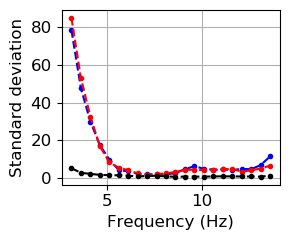

In [17]:
plt.figure(figsize=(3,2.5))
plt.plot(freqs[(freqs>=freq_lb[0])&(freqs<=freq_ub[0])][::5], 
         np.std(np.stack(vels_light[0]),axis=0)[::5],'.--b',label='Light-weight')
plt.plot(freqs[(freqs>=freq_lb[0])&(freqs<=freq_ub[0])][::5], 
         np.std(np.stack(vels_mid[0]),axis=0)[::5],'.--r',label='Mid-weight')    
plt.plot(freqs[(freqs>=freq_lb[0])&(freqs<=freq_ub[0])][::5], 
         np.std(np.stack(vels_heavy[0]),axis=0)[::5],'.--k',label='Heavy')
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Standard deviation', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()
plt.tight_layout()
plt.savefig(f'figures/{_x0}/freq_conv_weights.svg',format='svg')

## Convergence test

In [10]:
def convergence_test(max_sample_num,windows,bt_times,sigma,
                     x0,start_x,end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref):
    ridge_vel_std = np.empty((len(freq_lb),max_sample_num))
    for bt_size in tqdm(range(1,max_sample_num+1)):
        ridge_vel,freqs = bootstrap_disp(windows,bt_size,bt_times,sigma,x0,start_x,end_x,
                                         ref_freq_idx,freq_lb,freq_ub,vel_ref)
        for mode in range(len(freq_lb)):
            ridge_vel_std[mode,bt_size-1] = np.sum(np.std(ridge_vel[mode],axis=0))
    return ridge_vel_std

In [104]:
bt_sample_num = 60
ridge_vel_heavy_std = convergence_test(bt_sample_num,windows_heavy,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_mid_std = convergence_test(bt_sample_num,windows_mid,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)
ridge_vel_light_std = convergence_test(bt_sample_num,windows_light,bt_times,sigma,
                                 _x0,_start_x,_end_x,ref_freq_idx,freq_lb,freq_ub,vel_ref)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [18]:
with open('data/diff_weight_convergence.pkl', 'rb') as f: 
    ridge_vel_light_std, ridge_vel_mid_std, ridge_vel_heavy_std = pickle.load(f)

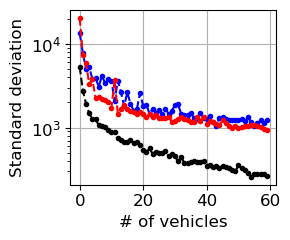

In [19]:
for mode in [0]:
    plt.figure(figsize=(3,2.5))
    plt.semilogy(ridge_vel_light_std[mode],'.--b',label='Light-weight')
    plt.semilogy(ridge_vel_mid_std[mode],'.--r',label='Mid-weight')    
    plt.semilogy(ridge_vel_heavy_std[mode],'.--k',label='Heavy')
    plt.xlabel('# of vehicles', fontsize=12)
    plt.ylabel('Standard deviation', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
#     plt.ylim([])
#     plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'figures/{_x0}/mode{mode+1}_weights.svg',format='svg')

In [106]:
# with open('data/diff_weight_convergence.pkl', 'wb') as f: 
#     pickle.dump([ridge_vel_light_std, ridge_vel_mid_std, ridge_vel_heavy_std], f)